In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
cos = nn.CosineSimilarity(dim=0, eps=1e-9)

In [2]:
A = torch.tensor([0.0, 1.0, 0.0, 0.0])
B = torch.tensor([1.0, 1.0, 0.0, 0.0])

In [3]:
cos(A,B)

tensor(0.7071)

In [4]:
from models import ConvNet
from utils import *
from torch.utils.data import DataLoader

In [5]:
# Define transformation (convert images to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

# Load the training dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [6]:
device = "cuda"

In [7]:
model1 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)
model2 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)
model0 = {k: v.clone().detach() for k, v in model1.state_dict().items()}
model2.load_state_dict(model1.state_dict())

num feat 2048
num feat 2048


<All keys matched successfully>

In [8]:
optimizer1 = optim.SGD(model1.parameters(), lr=0.001)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001)

In [9]:
# train with benign dataset

train_op(model1, test_loader, optimizer1, epochs=1, print_train_loss=True)

[2.3, 2.25, 2.21, 2.16, 2.13, 2.09, 2.05, 2.01, 1.98, 1.96, 1.93, 1.9, 1.87, 1.85, 1.82, 1.79, 1.77, 1.75, 1.73, 1.71, 1.69, 1.67, 1.65, 1.63, 1.62, 1.6, 1.59, 1.57, 1.56, 1.54, 1.53, 1.52, 1.5, 1.49, 1.48, 1.46, 1.45, 1.44, 1.43, 1.42, 1.41, 1.4, 1.39, 1.38, 1.37, 1.36, 1.35, 1.34, 1.33, 1.32, 1.31, 1.3, 1.3, 1.29, 1.28, 1.27, 1.26, 1.26, 1.25, 1.24, 1.23, 1.23, 1.22, 1.21, 1.21, 1.2, 1.19, 1.19, 1.18, 1.17, 1.17, 1.17, 1.16, 1.15, 1.15, 1.14, 1.14, 1.13, 1.12]


{'loss': 1.5049339866638183}

In [10]:
train_op_tr_flip(model2, test_loader, optimizer2, epochs=1, class_num=10, print_train_loss=True)

[2.22, 2.07, 2.09, 1.99, 2.04, 1.91, 1.95, 1.86, 1.88, 1.82, 1.85, 1.66, 1.72, 1.76, 1.69, 1.72, 1.68, 1.57, 1.6, 1.58, 1.61, 1.59, 1.56, 1.54, 1.55, 1.49, 1.42, 1.46, 1.41, 1.45, 1.39, 1.36, 1.33, 1.39, 1.36, 1.32, 1.31, 1.35, 1.27, 1.36, 1.38, 1.3, 1.2, 1.32, 1.28, 1.25, 1.13, 1.15, 1.12, 1.25, 1.25, 1.25, 1.3, 1.23, 1.2, 1.08, 1.19, 1.13, 1.11, 1.23, 1.11, 1.1, 1.21, 1.08, 1.1, 1.03, 1.03, 1.06, 1.18, 1.02, 1.07, 1.12, 1.15, 0.98, 1.03, 1.08, 0.97, 1.1, 1.01]


{'loss': 1.386445916748047}

# Evaluate the model after training

In [11]:
# test the main task

eval_op_ensemble([model1], train_loader)

{'test_accuracy': 0.7317333333333333}

In [12]:
eval_op_ensemble([model2], train_loader)

{'test_accuracy': 0.6182166666666666}

In [13]:
# test the attack success rate

eval_op_ensemble_tr_lf_attack([model1], train_loader).items()

dict_items([('accuracy', 0.016166666666666666)])

In [14]:
eval_op_ensemble_tr_lf_attack([model2], train_loader).items()

dict_items([('accuracy', 0.9013333333333333)])

In [15]:
# model1

In [16]:
# cos between trained models
flat_model0 = flat_dict_grad(model0)
flat_model1 = flat_dict_grad(model1.state_dict())
flat_model2 = flat_dict_grad(model2.state_dict())

In [17]:
flat_model1 - flat_model0

tensor([-2.0318e-04,  8.5533e-06,  3.0941e-04,  ...,  5.2588e-04,
         1.1615e-03, -9.7164e-04], device='cuda:0')

In [18]:
cos = nn.CosineSimilarity(dim=0, eps=1e-11)
cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))

tensor(0.8570, device='cuda:0')

In [19]:
# analyzing critical parameters
# Towards Attack-tolerant Federated Learning via Critical Parameter Analysis
# use self-defined method to try

abs_delta = torch.abs(flat_model2 - flat_model1)

In [22]:
abs_delta

tensor([6.2451e-05, 8.9407e-07, 2.0802e-05,  ..., 1.6198e-04, 3.7230e-04,
        2.5532e-04], device='cuda:0')

In [24]:
data_np = abs_delta.cpu().detach().numpy()

In [25]:
data_np

array([6.2450767e-05, 8.9406967e-07, 2.0802021e-05, ..., 1.6197725e-04,
       3.7230179e-04, 2.5532208e-04], dtype=float32)

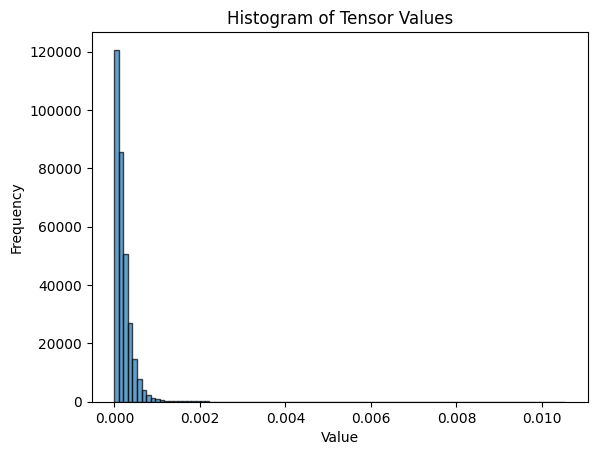

In [31]:

# data = torch.tensor([1, 1, 2, 1])

# Convert tensor to NumPy for plotting


# Plot histogram
plt.hist(data_np, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Tensor Values")
plt.show()

In [ ]:
def replace_top_r_percent(a, b, c, k):
    n = b.numel()
    top_k = max(1, int(n * (k / 100)))  # Ensure at least one element is selected
    threshold = torch.topk(b, top_k, sorted=True).values[-1]  # Get the r%-th largest value

    mask = b >= threshold  # Mask for top r% values
    result = torch.where(mask, c, a)  # Replace selected positions in a with c

    return result

# Example usage
a = torch.tensor([1, 3, -5, 1])
b = torch.tensor([0, 0, 2, 0])
c = torch.tensor([4, 3, 7, 6])

r = 25  # Top 25% replacement
output = replace_top_r_percent(a, b, c, r)
print(output)  # Expected: tensor([1, 3, 7, 1])



tensor([1, 3, 7, 1])


In [ ]:
# try combined model's cos and attack success rate

In [ ]:
crafted_model = replace_top_r_percent(flat_model1, abs_delta, flat_model2, k=0.25)

In [38]:
crafted_model

tensor([ 0.2269,  0.2908,  0.2841,  ..., -0.0035,  0.0177,  0.0174],
       device='cuda:0')

In [39]:
cos((flat_model1 - flat_model0), (crafted_model - flat_model0))

tensor(0.9488, device='cuda:0')

In [40]:
# restore the weights back to the model to test attack success rate
def restore_dict_grad(flat_grad, model_dict):
    restored_grad = {}
    start = 0
    for name, param in model_dict.items():
        num_elements = param.numel()
        restored_grad[name] = flat_grad[start:start + num_elements].view(param.shape)
        start += num_elements
    return restored_grad

In [41]:
restored_crafted = restore_dict_grad(crafted_model, model2.state_dict())

In [43]:
model2.load_state_dict(restored_crafted )

<All keys matched successfully>

In [44]:
eval_op_ensemble([model2], train_loader)

{'test_accuracy': 0.6397166666666667}

In [45]:
eval_op_ensemble_tr_lf_attack([model2], train_loader).items()

dict_items([('accuracy', 0.769)])

In [47]:
dist = torch.cdist

In [48]:
dist(torch.tensor([1,0]), torch.tensor([1,1]))

RuntimeError: cdist only supports at least 2D tensors, X1 got: 1D

In [50]:
def cosine_similarity_1d(tensor1, tensor2):
    return torch.nn.functional.cosine_similarity(tensor1, tensor2, dim=0)

# Example usage
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([4.0, 5.0, 6.0])
cos_sim = cosine_similarity_1d(a, b)
print(cos_sim.item())

0.9746317863464355


In [51]:
def pairwise_cosine_similarity(A):
    n = A.shape[0]
    cos_sims = []
    
    for i in range(n):
        for j in range(i + 1, n):
            cos_sim = torch.nn.functional.cosine_similarity(A[i], A[j], dim=0)
            cos_sims.append(cos_sim.item())
    
    cos_sims = torch.tensor(cos_sims)
    return cos_sims.mean().item(), cos_sims.std().item()

# Example usage
A = torch.randn(5, 10)  # 5 vectors of dimension 10
mean_sim, std_sim = pairwise_cosine_similarity(A)
print("Mean Cosine Similarity:", mean_sim)
print("Standard Deviation:", std_sim)

Mean Cosine Similarity: 0.01625511609017849
Standard Deviation: 0.24390845000743866
